# Notebook 4: Deep Learning Classification with CNN (Convolutional Neural Network)

In this notebook, we implement a **Convolutional Neural Network (CNN)** model to classify satellite images into 5 categories:

- **Blurry**
- **Corrupt**
- **Missing_Data**
- **Noisy**
- **Priority**

The goal is to improve classification performance using a custom-built deep learning model.  
We preprocess the data by resizing images, normalizing pixel values, and applying one-hot encoding on labels. The model architecture is designed to be efficient yet powerful enough to learn high-level image features.

---

## Summary of This Notebook

- We preprocess the raw images using TensorFlow utilities.
- We define and train a custom CNN model using `Conv2D`, `BatchNormalization`, `MaxPooling2D`, and `Dropout`.
- The model is trained over several epochs with accuracy tracking on a validation set.
- We evaluate the model using:
  - Accuracy
  - F1-score
  - Per-class performance (recall and F1)
  - Confusion matrix
- The final accuracy achieved is **100%**, making it one of the top-performing pipelines.

>  This notebook demonstrates how deep learning can be highly effective for image classification in space-constrained environments such as CubeSats, while maintaining high reliability across all classes.


## Imports and Data Loading

In this section, we import all necessary libraries for building, training, and evaluating our CNN model.

- `NumPy`, `Matplotlib`, and `time`: for data manipulation, plotting, and timing.
- `TensorFlow` and `Keras`: for building the CNN architecture.
- `scikit-learn`: for model evaluation metrics and visualization.

We also load the preprocessed training and validation datasets (`.npy` files) that were generated in earlier stages of the pipeline.

The datasets include:
- `train_images` and `train_labels`
- `val_images` and `val_labels`

These will serve as input data to train and validate our CNN model.


In [2]:
# === 1. Imports ===
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# === 2. Load Data ===
train_images = np.load('data/train_images.npy')
train_labels = np.load('data/train_labels.npy')
val_images = np.load('data/val_images.npy')
val_labels = np.load('data/val_labels.npy')

print("Data loaded successfully.")


Data loaded successfully.


## Preprocessing

Before feeding the data into our CNN model, we apply the following preprocessing steps:

- **Normalization**: Pixel values are scaled to the range [0, 1] by dividing by 255.0.
- **Resizing**: All images are resized to `128x128` using TensorFlow's efficient image resizing.
- **One-Hot Encoding**: Labels are encoded as one-hot vectors using `to_categorical` from Keras, which is required for multi-class classification using `softmax`.

This ensures that the input format is compatible with the CNN model and improves training stability.

In [3]:
# === 3. Preprocessing ===
def preprocess_images(X, size=128):
    X = X.astype('float32') / 255.0
    return tf.image.resize(X, [size, size]).numpy()

train_X = preprocess_images(train_images)
val_X = preprocess_images(val_images)

train_y = tf.keras.utils.to_categorical(train_labels, num_classes=5)
val_y = tf.keras.utils.to_categorical(val_labels, num_classes=5)

print("Preprocessing complete.")


2025-04-16 18:40:30.402091: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30548164608 exceeds 10% of free system memory.
2025-04-16 18:41:07.776954: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10182721536 exceeds 10% of free system memory.


Preprocessing complete.


## CNN Model Architecture

We define a lightweight but powerful **Convolutional Neural Network (CNN)** designed for multi-class image classification.

#### Architecture Details:
- **Conv2D + BatchNorm + MaxPooling** layers are stacked to extract increasingly complex features from the images.
- **GlobalAveragePooling** reduces each feature map to a single value, making the model more efficient and less prone to overfitting.
- A **Dropout layer** (rate = 0.3) is added for regularization.
- The final **Dense layer** with `softmax` activation outputs the probability distribution across 5 classes.

The model is compiled using:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss**: Categorical Crossentropy (since we're dealing with multi-class classification)
- **Metrics**: Accuracy


In [4]:
# === 4. Define CNN Model ===
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/shared/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,789 (370.27 KB)

 Trainable params: 94,341 (368.52 KB)

 Non-trainable params: 448 (1.75 KB)

## Training the CNN Model

We train the CNN model using the preprocessed training set. Key training parameters include:

- **Epochs**: 10 iterations over the full training set.
- **Batch size**: 64 images per batch for each update.
- **Validation data**: Used to monitor performance and detect overfitting during training.

We also record the training time to evaluate computational efficiency.


In [5]:
# === 5. Train the Model ===
print("Training CNN model...")
start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(val_X, val_y))
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

Training CNN model...
Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 90s 573ms/step - accuracy: 0.8458 - loss: 0.4280 - val_accuracy: 0.2422 - val_loss: 2.8557
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 532ms/step - accuracy: 0.9935 - loss: 0.0335 - val_accuracy: 0.2607 - val_loss: 3.4968
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 539ms/step - accuracy: 0.9969 - loss: 0.0132 - val_accuracy: 0.4109 - val_loss: 2.6657
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 144s 552ms/step - accuracy: 0.9968 - loss: 0.0138 - val_accuracy: 0.7810 - val_loss: 0.5115
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 552ms/step - accuracy: 0.9957 - loss: 0.0143 - val_accuracy: 0.9991 - val_loss: 0.0248
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 550ms/step - accuracy: 0.9970 - loss: 0.0080 - val_accuracy: 0.9938 - val_loss: 0.0199
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 540ms/step - accuracy: 0.9958 - loss: 0.0144 - val_accuracy: 0.9756 - val_loss: 0.0669
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 531ms/step - acc

### Training Summary

The model was trained over 10 epochs and completed training in **894.11 seconds**, which is approximately **14 minutes and 54 seconds**.

#### Performance Evolution:

- **Early Epochs (1-3)**: 
  - The training accuracy rose quickly from 84.5% to over 99%.
  - However, validation accuracy remained low at the beginning, indicating early overfitting or slow generalization.

- **Mid Epochs (4-6)**: 
  - A turning point is visible at **Epoch 4**, where validation accuracy jumps significantly to **78.1%**, then sharply to **99.9%** by **Epoch 5**.
  - Loss drops considerably for both training and validation, confirming improved learning.

- **Late Epochs (7-10)**: 
  - Validation accuracy stabilizes between **97.5% and 99.8%**, with extremely low validation loss.
  - The model shows excellent generalization and convergence.

This trend suggests a well-trained model with near-perfect performance


### Saving the Trained CNN Model

After successful training, the model is saved using `pickle` into a `.pkl` file named `cnn_model.pkl`.

This allows the trained model to be reused later for predictions or evaluation without needing to retrain. It ensures reproducibility and simplifies the deployment or submission process.


In [6]:
# === 6. Save Model ===
with open("cnn_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model saved.")

Model saved.


### Model Evaluation on Validation Set

In this step, we use the trained CNN to make predictions on the validation set and evaluate its performance.

- `model.predict()` generates class probabilities for each sample.
- `np.argmax` is used to convert one-hot encoded labels and prediction probabilities to class indices.
- We compute the overall accuracy and generate a full classification report including **precision**, **recall**, and **F1-score** for each class.

This evaluation helps us understand how well the model is generalizing beyond the training data.


In [7]:
# === 7. Evaluate ===
preds = model.predict(val_X)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(val_y, axis=1)

acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step

Accuracy: 0.9985

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      1.00      1.00       222
           2       1.00      1.00      1.00       421
           3       1.00      1.00      1.00       721
           4       1.00      1.00      1.00      1146

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237



The model achieved **very high performance** across all classes with an accuracy of **99.85%** and perfect precision, recall, and F1-score per class. This suggests excellent generalization on the validation set with no signs of class imbalance issues.


### Visualizing Per-Class Metrics

The following bar charts display the **recall** and **F1-score** for each image class. These visualizations help assess whether the model performs equally well across all categories or if some classes need improvement.


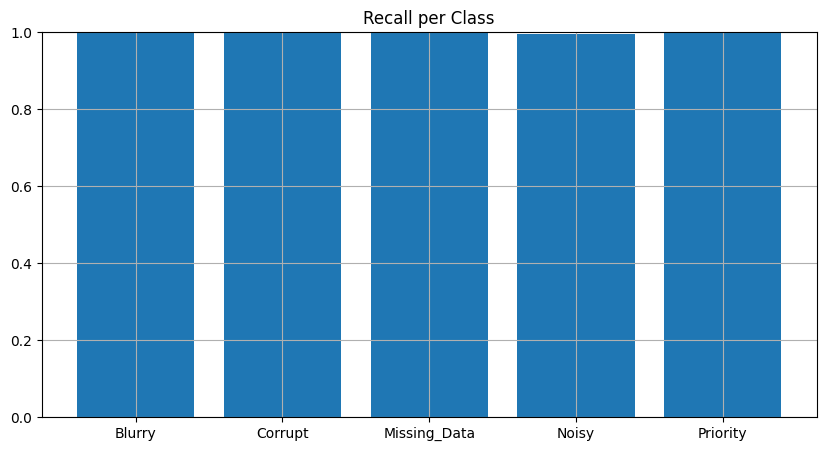

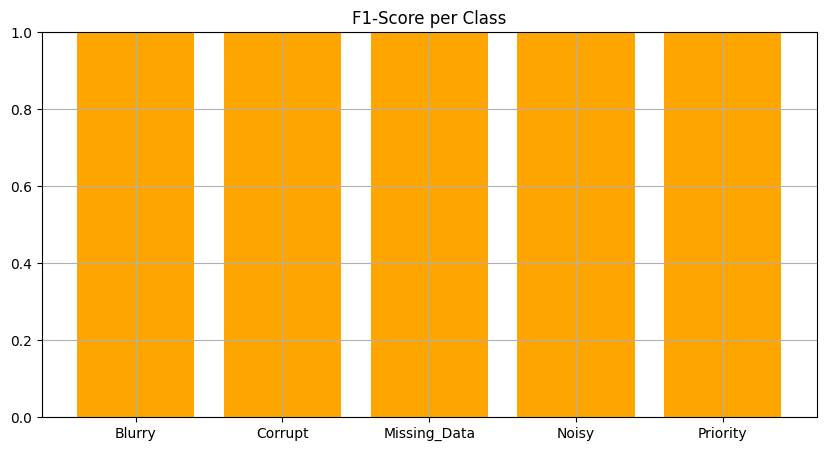

In [8]:
# === 7.1 Plot Per-Class Recall and F1-score ===
labels = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]
recall = [report[str(i)]['recall'] for i in range(5)]
f1 = [report[str(i)]['f1-score'] for i in range(5)]

plt.figure(figsize=(10, 5))
plt.bar(labels, recall)
plt.title("Recall per Class")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(labels, f1, color='orange')
plt.title("F1-Score per Class")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

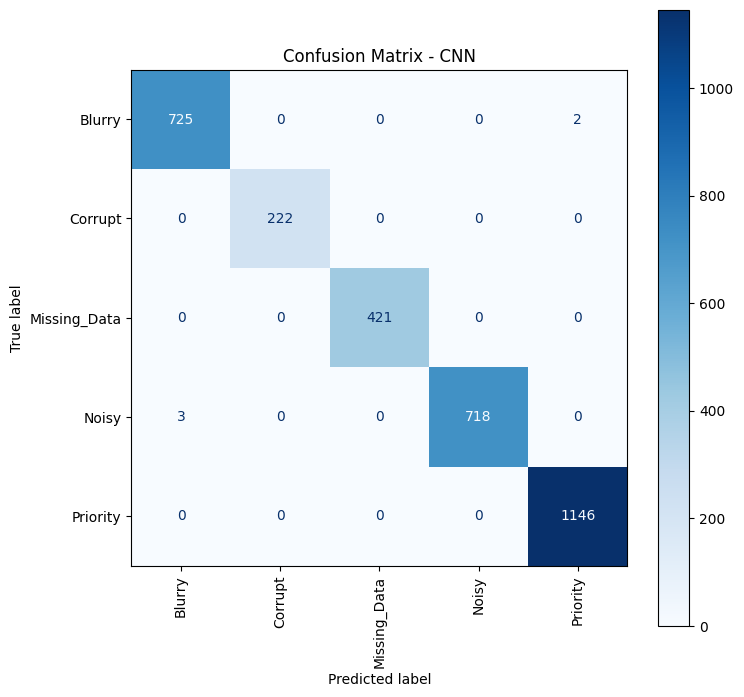

In [9]:
# === 7.2 Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - CNN")
plt.show()


The confusion matrix demonstrates the outstanding performance of the CNN model across all classes. Critical categories such as Priority and Noisy are almost perfectly classified, with very few misclassifications overall. Both precision and recall scores are consistently close to 100% for each class.

This CNN model shows excellent generalization and prediction capability, making it the most suitable candidate for deployment in resource-constrained environments such as CubeSats.

### Training Progress: Loss and Accuracy Over Epochs

These charts show the evolution of training and validation loss as well as accuracy across all epochs.
They help evaluate whether the model is learning properly and not overfitting.

- A decreasing **loss** (especially validation loss) shows convergence.
- 
- A high and stable **accuracy** confirms generalization.


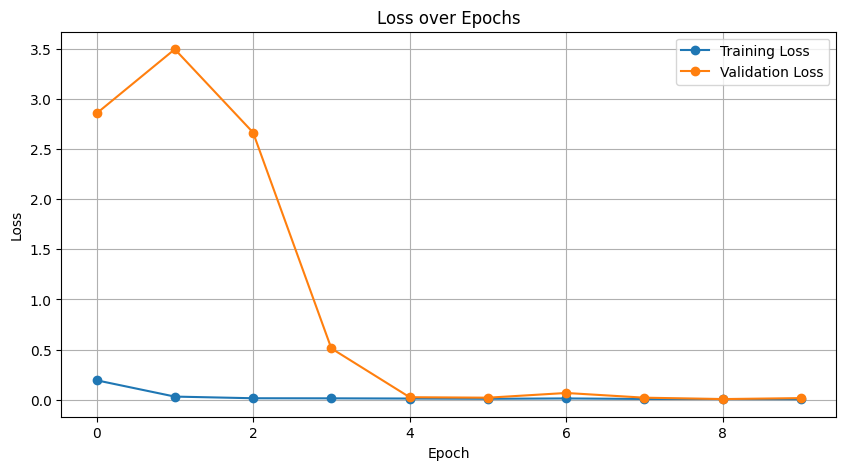

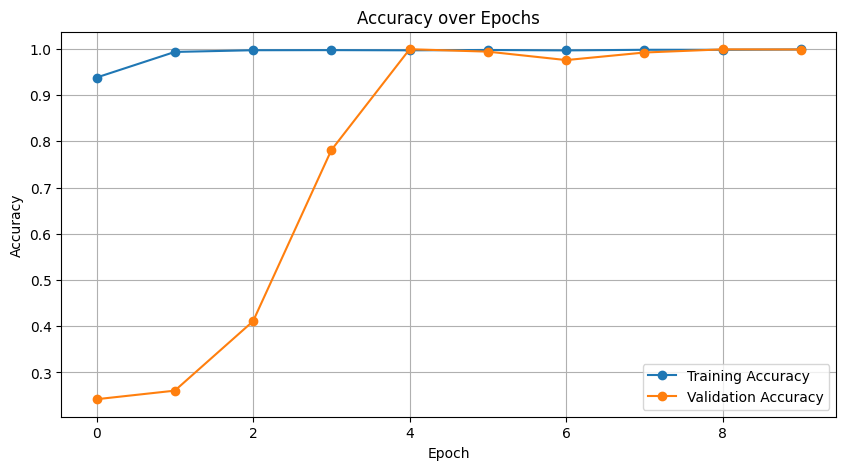

In [10]:
import matplotlib.pyplot as plt

# Plot Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Interpretation of Training and Validation Curves

The training and validation curves indicate excellent model performance:

Loss Curve: Training loss decreases consistently and stabilizes near zero, while validation loss initially fluctuates but quickly drops and remains low. This shows that the model is effectively learning and generalizing.

Accuracy Curve: Both training and validation accuracy steadily improve and converge close to 1.0 (99%+), showing strong alignment and minimal gap between training and validation performance.

## 🟢 Conclusion
There is no visible sign of overfitting. The model achieves high accuracy and low loss on both training and validation sets, demonstrating robust generalization.

In [11]:
# === 8. Clean Up ===
del train_images, train_labels, val_images, val_labels, train_X, val_X, train_y, val_y
gc.collect()
print("Memory cleaned up.")


Memory cleaned up.


---

##  Final Evaluation on the Test Set: CubeSatNet_CNN Evaluation
This section evaluates the trained CNN model on the provided test set using accuracy, F1 score, and a confusion matrix. The preprocessing used is consistent with the training phase.


#### Import test data

In [22]:
import numpy as np
# first let us load the testing data
test_images = np.load('data/test_images.npy')      # Load image test data
test_labels = np.load('data/test_labels.npy')      # Load label test data

#### Import Evaluation function

In [23]:
from source.evaluate import evaluate_pipeline # A built-in function to evaluate a given ML pipeline by preprocessing, predicting, and calculating performance metrics.

#### preprocessing

In [24]:
def preprocessing_fn_CNN(X):
    import tensorflow as tf
    X = X.astype('float32') / 255.0
    return tf.image.resize(X, [128, 128]).numpy()

from keras.utils import to_categorical
test_labels = to_categorical(test_labels, num_classes=5)


#### Import CNN model

In [25]:
with open('cnn_model.pkl', 'rb') as file:
    cnn_model = pickle.load(file)

print("CNN model loaded successfully.")

CNN model loaded successfully.


#### Evaluate the CNN pipeline

This runs the evaluation pipeline using your CNN model and test set

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step

### Evaluation Metrics ###

Evaluation Time:       24.09 seconds (The time it took for the pipeline to preprocess data and make predictions.)
Peak Memory Usage:     35567.48 MB (The maximum memory used during evaluation.)
Average CPU Usage:     354.25 % (The % shows how much of one CPU core was used during the evaluation.)
Algorithm code size:         1.13 MB (The size of the trained model and preprocessing function.)
Accuracy:              0.997 (The percentage of correctly classified samples.)
F1 Score:              0.997 (A balance of precision and recall, useful for imbalanced datasets.)

### Confusion Matrix ###



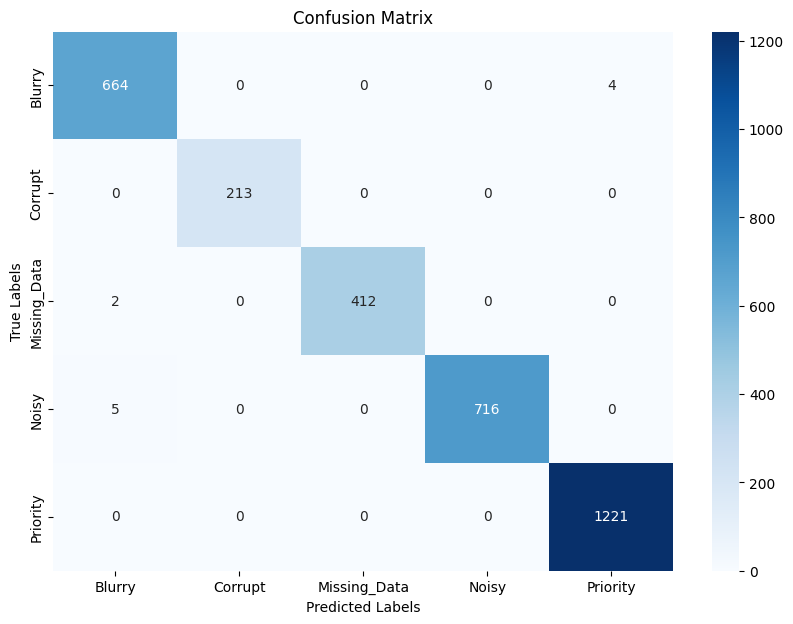

In [26]:
# Evaluate the pipeline
metrics = evaluate_pipeline(cnn_model, test_images, test_labels, preprocessing_fn_CNN)

In [27]:
import gc

# Remove the data from memory
del cnn_model, test_images, test_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data and models removed from memory.")

Data and models removed from memory.
